> Martin Fridrich 01/2025

# Waste product classification

## Data

In [63]:
#%pip install -q -r dl-env-requirements.txt

In [64]:
# print out tf version
import tensorflow as tf
print(f"Installed tensorflow version: {tf.__version__}")

Installed tensorflow version: 2.18.0


In [65]:
import os
import zipfile
import requests

class DataUtils():

    # Data download and extraction

    def __init__(self):
        self.data_dir = "data"
        self.data_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
        self.data_file = "o-vs-r-split-reduced-1200.zip"
        self.validation_split = 0.2
        self.img_size = (150, 150)
        self.batch_size = 32

    def download_data(self):
        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)
            
        data_path = os.path.join(self.data_dir, self.data_file)
        
        if not os.path.exists(data_path):
            print("Downloading data...")
            response = requests.get(self.data_url)
            with open(data_path, "wb") as f:
                f.write(response.content)
            
            print("Extracting data...")
            with zipfile.ZipFile(data_path, "r") as zip_ref:
                zip_ref.extractall(self.data_dir)
            
            #print("Removing zip file...")
            #os.remove(data_path)
            
            print("Data download and extraction completed.")
        else:
            print("Data already exists.")
        
        return self
    # Data generators

    def _get_train_augmentation(self):
        return tf.keras.preprocessing.image.ImageDataGenerator(
            validation_split=self.validation_split,
            rescale=1.0/255.0,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        )
    
    def _get_validation_augmentation(self):
        return tf.keras.preprocessing.image.ImageDataGenerator(
            validation_split=self.validation_split,
            rescale=1.0/255.0)

    def _get_test_augmentation(self):
        return tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

    def initialize_data_generators(self):
        train_datagen = self._get_train_augmentation()
        validation_datagen = self._get_validation_augmentation()
        test_datagen = self._get_test_augmentation()

        common_params = {
            "target_size": self.img_size,
            "batch_size": self.batch_size,
            "class_mode": "binary"
        }

        self.train_generator = train_datagen.flow_from_directory(
            os.path.join(self.data_dir, "o-vs-r-split/train/"),
            subset="training",
            **common_params)
        
        self.validation_generator = validation_datagen.flow_from_directory(
            os.path.join(self.data_dir, "o-vs-r-split/train/"),
            subset="validation",
            **common_params)
        
        self.test_generator = test_datagen.flow_from_directory(
            os.path.join(self.data_dir, "o-vs-r-split/test/"),
            shuffle=False,
            **common_params)
        
        return self

data = DataUtils().download_data().initialize_data_generators()
print(f"Train data generator consists of  {len(data.train_generator)} batches.")

Data already exists.
Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Found 200 images belonging to 2 classes.
Train data generator consists of  25 batches.


## Modeling

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

class Modeling():
    def __init__(self, data, model_name):
        self.data = data
        self.model_name = model_name
        self.model = None
        self.history = None
        self.feature_extractor = None

    def load_feature_extractor(self, trainable_layers=[]):
        vgg = tf.keras.applications.VGG16(
            include_top=False,
            weights="imagenet",
            input_shape = data.img_size + (3,))
        for layer in vgg.layers:
            if layer.name not in trainable_layers:
                layer.trainable = False
            else:
                layer.trainable = True

        output = vgg.layers[-1].output
        output = tf.keras.layers.Flatten()(output)
        self.feature_extractor = tf.keras.Model(vgg.input, output)
        return self
    
    def build_model(self):
        inputs = tf.keras.layers.Input(shape=data.img_size + (3,))
        x = self.feature_extractor(inputs, training=False)
        x = tf.keras.layers.Dense(512, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(512, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
        self.model = tf.keras.Model(inputs, outputs)
        self.model.name = self.model_name
        return self
    
    def compile_model(self):
        self.model.compile(
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
            loss="binary_crossentropy",
            metrics=["accuracy"])
        return self
    
    def _get_callbacks(self):

        class LossHistory(tf.keras.callbacks.Callback):
            def on_train_begin(self, logs={}):
                self.losses = []
                self.lr = []
                
            def on_epoch_end(self, epoch, logs={}):
                self.losses.append(logs.get("loss"))
                self.lr.append(exp_decay(epoch))
                print("lr:", exp_decay(len(self.losses)))

        def exp_decay(epoch):
            base_lr = 1e-4
            k = 0.1
            return base_lr * np.exp(-k*epoch)
        
        return [LossHistory(),
            tf.keras.callbacks.LearningRateScheduler(exp_decay),
            tf.keras.callbacks.EarlyStopping(
                monitor = "val_loss", patience = 4, mode = "min", min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(
                self.model_name+".keras", monitor="val_loss", save_best_only=True, mode="min")]

    def train_model(self, epochs=10):
        self.history = self.model.fit(
            self.data.train_generator,
            validation_data=self.data.validation_generator,
            epochs=epochs,
            verbose=1,
            callbacks = self._get_callbacks())
        return self
    
    def plot_history(self):
        
        acc = self.history.history["accuracy"]
        val_acc = self.history.history["val_accuracy"]
        loss = self.history.history["loss"]
        val_loss = self.history.history["val_loss"]

        epochs = range(len(acc))

        plt.plot(epochs, acc, "r", label="Training accuracy")
        plt.plot(epochs, val_acc, "b", label="Validation accuracy")
        plt.title("Training and validation accuracy")
        plt.figure()
        plt.plot(epochs, loss, "r", label="Training Loss")
        plt.plot(epochs, val_loss, "b", label="Validation Loss")
        plt.title("Training and validation loss")
        plt.legend()
        plt.show()
        return self
    
    def print_classification_report(self):
        y_raw_pred = self.model.predict(self.data.test_generator, verbose=0)
        y_pred = np.round(y_raw_pred, decimals=0).astype(np.int32)
        y_true = self.data.test_generator.classes
        print(classification_report(y_true, y_pred))
        return self

Epoch 1/10


/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5879 - loss: 0.7588lr: 9.048374180359596e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.5904 - loss: 0.7547 - val_accuracy: 0.8000 - val_loss: 0.4902 - learning_rate: 1.0000e-04
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7445 - loss: 0.5578lr: 8.187307530779819e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.7449 - loss: 0.5567 - val_accuracy: 0.8150 - val_loss: 0.4447 - learning_rate: 9.0484e-05
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8133 - loss: 0.4195lr: 7.408182206817179e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.8123 - loss: 0.4208 - val_accuracy: 0.8850 - val_loss: 0.3765 - learning_rate: 8.1873e-05
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8216 - loss: 0.4597lr: 6.703200460356394e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.8216 - loss: 0.4589 - val_accuracy: 0.8750 - val_loss: 0.3506 - learning_rate: 7.

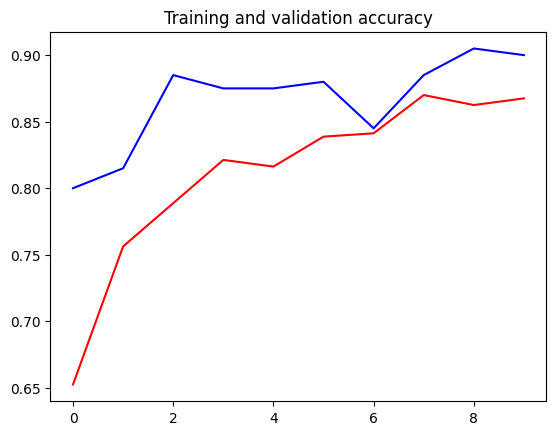

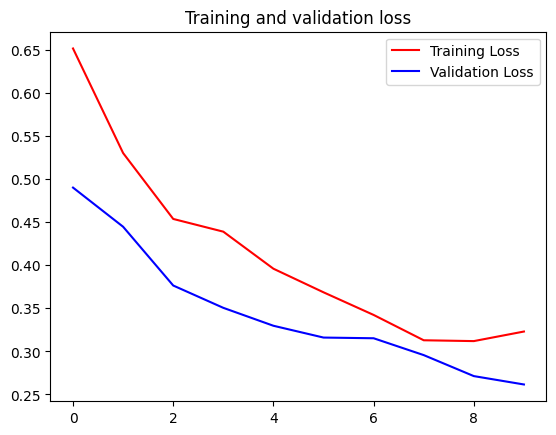

In [67]:
freezed_model = Modeling(data, "freezed_or_vgg16").load_feature_extractor()\
    .build_model().compile_model().train_model(epochs=10).plot_history()

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6073 - loss: 0.7391lr: 9.048374180359596e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.6093 - loss: 0.7366 - val_accuracy: 0.7850 - val_loss: 0.4830 - learning_rate: 1.0000e-04
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7559 - loss: 0.5230lr: 8.187307530779819e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.7557 - loss: 0.5233 - val_accuracy: 0.8900 - val_loss: 0.3679 - learning_rate: 9.0484e-05
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8025 - loss: 0.4588lr: 7.408182206817179e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8028 - loss: 0.4581 - val_accuracy: 0.8900 - val_loss: 0.3237 - learning_rate: 8.1873e-05
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8406 - loss: 0.3524lr: 6.703200460356394e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8405 - loss: 0.3525 - val_accuracy: 0.9050 - val_loss: 0.2676 - learni

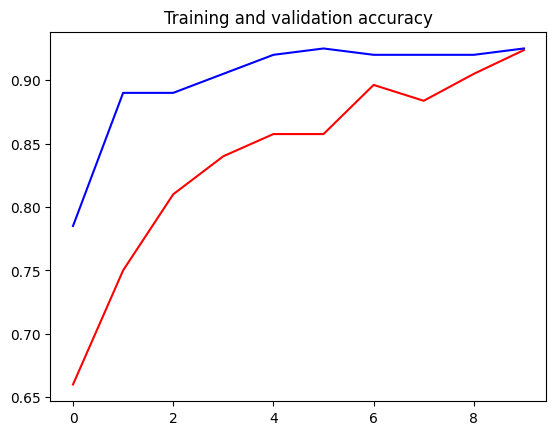

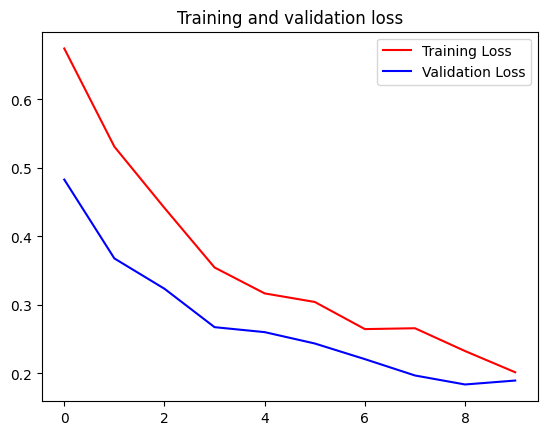

In [68]:
finetuned_model = Modeling(data, "finetuned_or_vgg16").load_feature_extractor(trainable_layers=["block5_conv3"])\
    .build_model().compile_model().train_model(epochs=10).plot_history()

In [69]:
freezed_model.model.evaluate(data.test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8575 - loss: 0.3564


[0.33350762724876404, 0.8650000095367432]

In [73]:
# evaluation on the test set
# plotting examples of correct and incorrect predictions

#